# Exercise 4 
Description: Fit simple model to CMS Run I Higgs to gamma, gamma data
- Created CMSDAS 2016 LPC Fermilab
- Updated CMSDAS 2019 LPC Fermilab

In [1]:
import os,sys
from time import sleep
sys.path.insert(0,'../python')
from histutil import *
import ROOT as rt

Welcome to JupyROOT 6.12/07


In [2]:
#------------------------------------------------------------------
# make a histogram for each di-photon category
def makeHistograms(table, prefix=''):
    # determine minimum and maximum di-photon mass
    mass0 = table[0][0]       # mass for row 0
    mass1 = table[1][0]       # mass for row 1
    massn = table[-1][0]      # mass for last row
    mstep = mass1-mass0       # mass step size
    mmin  = mass0-0.5*mstep   # minimum mass
    mmax  = massn+0.5*mstep   # maximum mass

    # first column is the mass, so skip it
    variables = table.variables()[1:]
    nrows = len(table)
    ncols = len(variables)
    print 
    print 'bins: %4d\tcategories: %4d\tmin, max: %5.1f, %5.1f GeV' % \
      (nrows, ncols, mmin, mmax)

    # create a histogram for each category
    h = [None]*ncols
    xtitle = '#font[12]{m_{#gamma#gamma}} (GeV)'
    for ii, name in enumerate(variables):
        hname = '%s%s' % (prefix, name)
        print '\t%s' % hname
        h[ii] = mkhist1(hname, xtitle, 'count / 0.8 GeV', nrows, mmin, mmax)
        h[ii].SetMarkerSize(0.40)
        h[ii].GetXaxis().SetTitleSize(0.08)
        h[ii].GetXaxis().SetTitleOffset(0.95)
        h[ii].GetYaxis().SetTitleOffset(1.15)
        h[ii].GetYaxis().SetTitleSize(0.08)
        for jj in xrange(nrows):
            h[ii].SetBinContent(jj+1, table[jj][ii+1])
    return h

In [3]:
def plotHistograms(h, filename, title,
                   xoff=10, yoff=10, xwid=1000, ywid=1000):        
    c = rt.TCanvas(filename, title, xoff, yoff, xwid, ywid)
    c.Divide(4, 4)
    for ii in xrange(len(h)-1):
        c.cd(ii+1)
        h[ii].Draw('ep')
    c.Update()
    return c

In [4]:
# create a map<string, TH1*> 
def makeHmap():
    rt.gROOT.ProcessLine('''
    #include <map>
    #include <string>
    #include "TH1.h"
    struct Hmap
    {
      void add(std::string name, TH1* h) {hmap[name] = h;}
      std::map<std::string, TH1*> hmap;
      std::map<std::string, TH1*>& operator()(){return hmap;}
    };
    ''')
    from ROOT import Hmap
    hmap = Hmap()
    return hmap        


bins:  100	categories:   11	min, max: 100.0, 180.0 GeV
	h7_c00
	h7_c01
	h7_c02
	h7_c03
	h7_c04
	h7_c05
	h7_c06
	h7_c07
	h7_c08
	h7_c09
	h7_c10

bins:  100	categories:   14	min, max: 100.0, 180.0 GeV
	h8_c00
	h8_c01
	h8_c02
	h8_c03
	h8_c04
	h8_c05
	h8_c06
	h8_c07
	h8_c08
	h8_c09
	h8_c10
	h8_c11
	h8_c12
	h8_c13
----------------------------
mass bins:        100
min[mass]:        100.0 GeV
max[mass]:        180.0 GeV
ndata(7TeV):    36351 events
ndata(8TeV):   195241 events
ndata(7+8TeV): 231592 events
ndatamax:      300000 events
----------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
RooDataHist::data[diphoton,x] = 2500 bins (36351 weights)
RooDataHist::data[diphoton,x] = 2500 bins (195241 weights)

RooWorkspace(HGG) HGG contents

variables
---------
(a1,a2,b,diphoton,mass,s,w,x)

p.d.f.s
-------
RooExponential::bmodel[ x=f c=1 ] = 0.0104621
RooAddPdf::

Info in <TCanvas::Print>: png file ./fig_hgg_7TeV.png has been created
Info in <TCanvas::Print>: png file ./fig_hgg_8TeV.png has been created


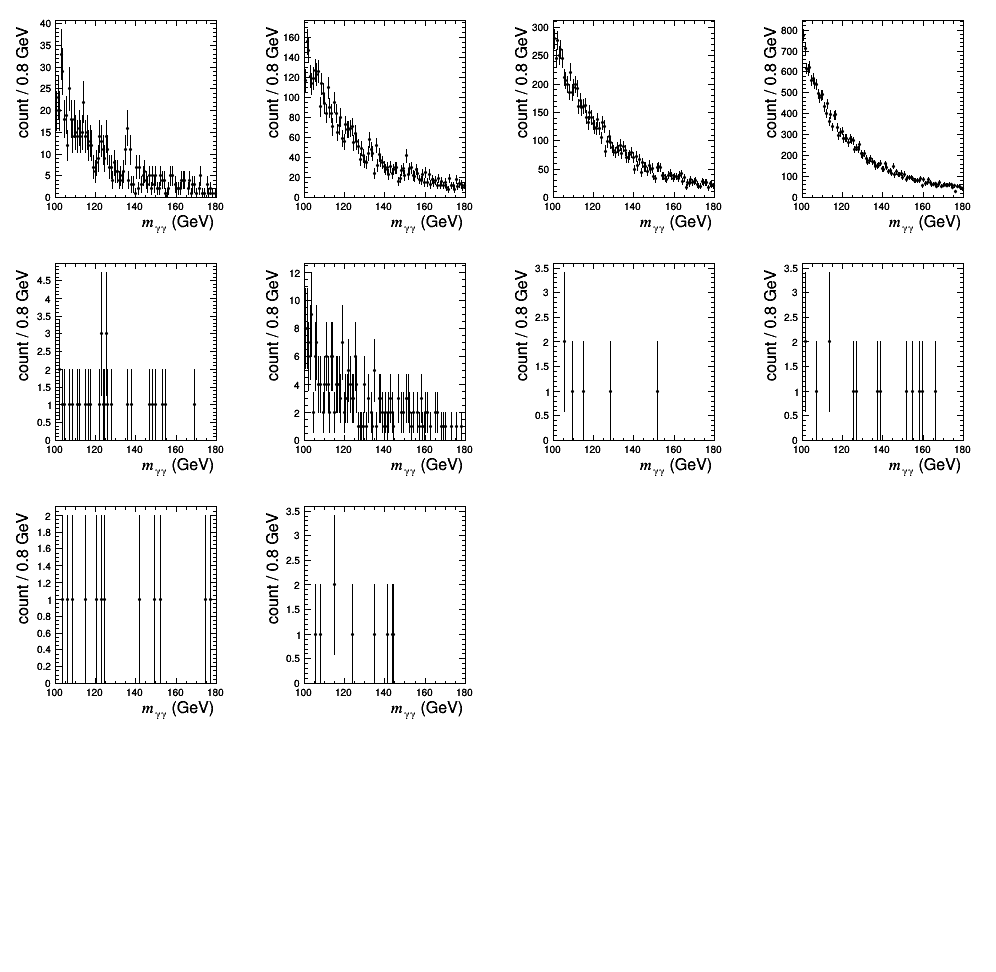

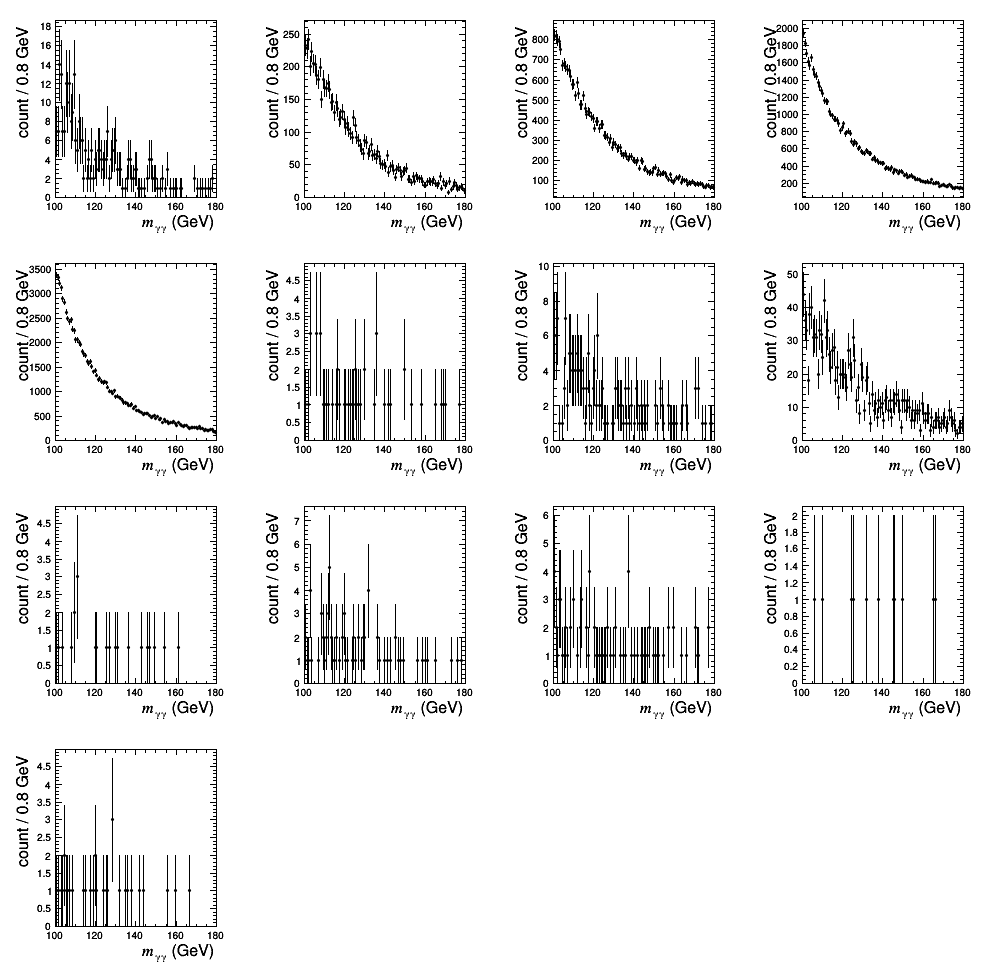

In [5]:
# set up standard graphics style (see python/histutil.py)
setStyle()
rt.gStyle.SetTitleYOffset(1.75)
    
#----------------------------------------
# read 7 TeV data into histograms
#----------------------------------------
data7TeV = Table('hgg_7TeV.txt')
h7 = makeHistograms(data7TeV, 'h7_')
c7 = plotHistograms(h7, 'fig_hgg_7TeV', '7 TeV')
c7.SaveAs('.png')
c7.Draw()
    
#----------------------------------------
# read 8 TeV data into histograms
#----------------------------------------
data8TeV = Table('hgg_8TeV.txt')
h8 = makeHistograms(data8TeV, 'h8_')
c8 = plotHistograms(h8, 'fig_hgg_8TeV', '8 TeV', 200)
c8.SaveAs('.png')
c8.Draw()
    
nbins   = h8[0].GetNbinsX()
massmin = h8[0].GetBinLowEdge(1)
massmax = massmin + nbins*h8[0].GetBinWidth(1)

#----------------------------------------
# create a workspace so that we can use
# its factory method
#----------------------------------------
# suppress all messages except those that matter
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.FATAL)
print "="*78    
wspace = rt.RooWorkspace('HGG')

#----------------------------------------
# create di-photon mass variable
# syntax:
# <name>[initial-val, min-val, max-val]
#----------------------------------------
wspace.factory('x[120.0, %f, %f]' % (massmin, massmax))
wspace.var('x').SetTitle('m_{#gamma#gamma}')
wspace.var('x').setUnit('GeV')

# define the set obs = (x)
wspace.defineSet('obs', 'x')

# make the set obs known to Python
obs  = wspace.set('obs')
    
#----------------------------------------
# define di-photon categories and create
# a binned dataset from the Root
# histograms identified by a RooFit
# category
#----------------------------------------
hmap = makeHmap()
    
# create categories
cat  = rt.RooCategory('diphoton',  'diphoton')
for h in h7:
    name = h.GetName()
    cat.defineType(name)
    hmap.add(name, h)

for h in h8:
    name = h.GetName()
    cat.defineType(name)
    hmap.add(name, h)

# create binned dataset from histograms.
# each histogram in hmap is associated with a diphoton
# category.
data = rt.RooDataHist('data', 'data', rt.RooArgList(obs), cat, hmap())
    
# add data to workspace.
# the RooCmdArg() is a workaround a PyROOT "feature"
getattr(wspace,'import')(data, rt.RooCmdArg())

#----------------------------------------
# create summed data for 7 and 8 TeV
# separately. specify what is to be
# used the
# syntax:
#    diphoton==diphoton::<category1>
# ORed together
#----------------------------------------
# 7 TeV data sum
cmd = joinfields(map(lambda i: 'diphoton==diphoton::h7_c%2.2d' % i,
                range(len(h7))), '||')
datasum7 = data.reduce(cmd)
datasum7.Print()
ndata7 = int(datasum7.sumEntries())

# 8 TeV data sum
cmd = joinfields(map(lambda i: 'diphoton==diphoton::h8_c%2.2d' % i,
                         range(len(h8))), '||')
datasum8 = data.reduce(cmd)
datasum8.Print()
ndata8 = int(datasum8.sumEntries())

# 7 + 8 TeV data sum
datasum = data.reduce('diphoton')
    
ndata   = ndata7 + ndata8
ndatamax= ndata / 100000
ndatamax= (ndatamax+1)*100000
        
print "-"*28
print "mass bins:     %6d" % nbins
print "min[mass]:      %7.1f GeV" % massmin
print "max[mass]:      %7.1f GeV" % massmax
print "ndata(7TeV):   %6d events" % ndata7
print "ndata(8TeV):   %6d events" % ndata8
print "ndata(7+8TeV): %6d events" % ndata
print "ndatamax:      %6d events" % ndatamax
print "-"*28

#----------------------------------------
# create background model
#----------------------------------------
wspace.factory('b[%d, 0.0, %d]' % (ndata8, ndatamax))
wspace.factory('a1[ 5.0, -50, 50]')
wspace.factory('a2[-1.0, -50, 50]')

# exp(-(a1*(x/100) + a2*(x/100)^2))
wspace.factory('expr::f("-(a1*(x/100)+a2*(x/100)^2)",a1,a2,x)')
# exp(c*x), c = 1 and x = f
wspace.factory('Exponential::bmodel(f, 1)')
bmodel  = wspace.pdf('bmodel')

#----------------------------------------
# create signal model
#----------------------------------------
wspace.factory('s[100, 0.0, 1000.0]')
wspace.factory('mass[125, %f, %f]' % (massmin, massmax))
wspace.factory('w[1.0, 0.1, 10]')
wspace.factory('Gaussian::smodel(x, mass, w)')

#----------------------------------------
# create background + signal model
#----------------------------------------
# According to Wouter, the following automatically
# produces an extended pdf 
# p(x|...) = exp(-(background+signal)) * PROD p(x_i|...)
wspace.factory('SUM::model(b*bmodel, s*smodel)')
model = wspace.pdf('model')

print "-"*80
wspace.Print()
print "-"*80

In [6]:
#----------------------------------------
# Fit
#----------------------------------------
print "fit model to data"
print "="*80

#d = data.reduce('diphoton==diphoton::h8_c01')
d = data.reduce('diphoton==diphoton')
b = d.sumEntries()
wspace.var('b').setVal(b)
    
swatch = rt.TStopwatch()
swatch.Start()
model.fitTo(d)
print "real time: %10.3f s" % swatch.RealTime()

fit model to data
real time:      0.238 s
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a1           5.00000e+00  1.00000e+01   -5.00000e+01  5.00000e+01
     2 a2          -1.00000e+00  1.00000e+01   -5.00000e+01  5.00000e+01
     3 b            2.31592e+05  3.00000e+04    0.00000e+00  3.00000e+05
     4 mass         1.25000e+02  8.00000e+00    1.00000e+02  1.80000e+02
     5 s            1.00000e+02  5.00000e+01    0.00000e+00  1.00000e+03
     6 w            1.00000e+00  4.50000e-01    1.00000e-01  1.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        3000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW STA

In [ ]:
vbkg = wspace.var('b')
vsig = wspace.var('s')
vmass= wspace.var('mass')
vwidth=wspace.var('w')
    
# Get results and compute a simple measure of signal significance
bkg   = vbkg.getVal()
ebkg  = vbkg.getError()
sig   = vsig.getVal()
esig  = vsig.getError()
mass  = vmass.getVal()
emass = vmass.getError()
width = vwidth.getVal()
ewidth= vwidth.getError()
zvalue= sig / esig

print "="*80
print "background: %10.1f +\-%-5.1f GeV" % (bkg, ebkg)
print "signal:     %10.1f +\-%-5.1f" % (sig, esig)
print "mass:       %10.1f +\-%-4.1f GeV" % (mass, emass)
print "width:      %10.1f +\-%-4.1f GeV" % (width, ewidth)
print "sig/esig:   %10.1f" % zvalue
print

# now plot results of fit
xframe = wspace.var('x').frame()
xframe.GetXaxis().SetNdivisions(505)
d.plotOn(xframe)
model.plotOn(xframe)
bmodel.plotOn(xframe, rt.RooFit.LineColor(2))

# hack to prevent display of background parameters
wspace.var('a1').setConstant()
wspace.var('a2').setConstant()
model.paramOn(xframe)

c1 = rt.TCanvas('fig_hgg_fit', 'fit', 10, 10, 500, 500)
xframe.SetMaximum(8000)
xframe.Draw()
c1.Draw()
c1.SaveAs('.png')